# Réseau CNN

### Préparation du Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os

# Lister les fichiers et dossiers à la racine de "MyDrive"
os.listdir('/content/drive/MyDrive/Colab Notebooks')

['data_processed.zip',
 'Untitled0.ipynb',
 'FC.ipynb',
 'Elliot feur',
 'CNN.ipynb']

In [ ]:
source = '/content/drive/MyDrive/Colab Notebooks/data_processed.zip'
dest   = '/content/'

!cp "$source" "$dest"

In [ ]:
!unzip -q data_processed.zip
!ls

data_processed	data_processed.zip  drive  sample_data


In [ ]:
# Install Keras 3 on colabs
!pip install -q keras-nightly

import os
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "torch"
import keras

print("Keras version:",keras.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.3 MB/s eta 0:00:00
Keras version: 3.8.0.dev2025012703


In [ ]:
print("CPU info:")
!lscpu |grep 'Model name'

CPU info:
Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz


In [ ]:
import shutil
import random
from sklearn.model_selection import train_test_split

# Répertoires des catégories d'images
categories = ['cars', 'locomotives', 'airplanes', 'bicycles', 'trucks', 'tractors', 'boats']
data_dir = '/content/data_processed'  # Répertoire contenant les sous-dossiers de catégories

# Créer les répertoires train, validation, test
base_dir = '/content/data_processed_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Créer des sous-dossiers pour chaque catégorie dans train, validation et test
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Séparer les images en ensembles train, validation et test
for category in categories:
    category_dir = os.path.join(data_dir, category)
    all_images = os.listdir(category_dir)

    # Diviser les images en train, validation, test (70%, 20%, 10%)
    train_images, temp_images = train_test_split(all_images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.333, random_state=42)  # 0.333 pour avoir 10% du total pour test

    # Déplacer les images dans les bons répertoires
    for img in train_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(train_dir, category, img))
    for img in val_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(val_dir, category, img))
    for img in test_images:
        shutil.copy(os.path.join(category_dir, img), os.path.join(test_dir, category, img))

print(f"Répertoires créés et images séparées avec succès.")


Répertoires créés et images séparées avec succès.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paramètres
img_height, img_width = 224, 224  # Taille des images (224x224x3)
batch_size = 32
num_classes = len(categories)

# Création d'un générateur d'images avec augmentation des données
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalisation des images (0 à 1)
    rotation_range=20,   # Rotation des images
    width_shift_range=0.2,  # Déplacement horizontal
    height_shift_range=0.2,  # Déplacement vertical
    shear_range=0.2,     # Cisaillement
    zoom_range=0.2,      # Zoom
    horizontal_flip=True,  # Retourner les images horizontalement
    fill_mode='nearest'   # Remplir les pixels manquants
)

# Flux de données d'entraînement, validation et test
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),  # Redimensionner les images
    batch_size=batch_size,
    class_mode='categorical',  # Type de label (catégorique)
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Normalisation uniquement pour les données de test
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

# Afficher le nombre d'images dans chaque ensemble
print(f'Entraînement : {train_generator.samples} images, Validation : {validation_generator.samples} images, Test : {test_generator.samples} images')


Found 5939 images belonging to 7 classes.
Found 1699 images belonging to 7 classes.
Found 851 images belonging to 7 classes.
Entraînement : 5939 images, Validation : 1699 images, Test : 851 images


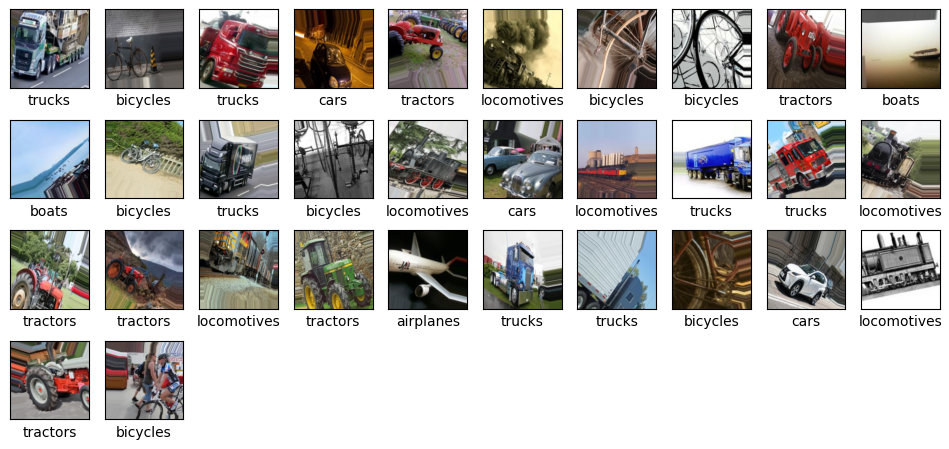

In [ ]:
import matplotlib.pyplot as plt

# Charger un batch d'images depuis le générateur
batch_size = 32
images_batch, labels_batch = next(train_generator)

# Calculer le nombre de lignes et de colonnes pour afficher les images
rows, cols = 5, 10  # 5 lignes et 10 colonnes (maximum 50 images)
plt.figure(figsize=(12, 6))
plt.subplots_adjust(top=1)

# Afficher les images
for i in range(min(batch_size, 50)):
    plt.subplot(rows, cols, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_batch[i])
    class_names = list(train_generator.class_indices.keys())
    plt.xlabel(class_names[labels_batch[i].argmax()])

plt.show()

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential()

# 1. Première couche convolutionnelle + max pooling
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# 2. Deuxième couche convolutionnelle + max pooling
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# 3. Troisième couche convolutionnelle + max pooling
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# 4. Quatrième couche convolutionnelle + max pooling
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# 5. Applatissement des images en un vecteur 1D
model.add(tf.keras.layers.Flatten())

# 6. Couche Fully Connected (FC) - 512 neurones + relu
model.add(tf.keras.layers.Dense(512, activation='relu'))

# 7. Couche Dropout pour éviter le sur-apprentissage
model.add(tf.keras.layers.Dropout(0.5))

# 8. Couche de sortie avec 7 neurones (pour les 7 classes) + softmax pour probabilité
model.add(tf.keras.layers.Dense(7, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compiler le modèle
model.compile(
    optimizer='adam',  # Optimiseur Adam
    loss='categorical_crossentropy',  # Perte pour classification multi-classes
    metrics=['accuracy']  # Mesure de l'exactitude
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Création d'un callback pour l'arrêt précoce (early stopping)
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Surveiller la perte de validation
    patience=5,  # Arrêter après 5 époques sans amélioration
    restore_best_weights=True  # Restaurer les meilleurs poids du modèle
)

In [ ]:
# Entraînement du modèle
history = model.fit(
    train_generator,  # Données d'entraînement
    epochs=100,  # Nombre d'époques
    validation_data=validation_generator,  # Données de validation
    callbacks=[early_stopping],  # Callback pour l'arrêt précoce
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 114s 599ms/step - accuracy: 0.2123 - loss: 2.0005 - val_accuracy: 0.3514 - val_loss: 1.6430
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 106s 573ms/step - accuracy: 0.3261 - loss: 1.6764 - val_accuracy: 0.3938 - val_loss: 1.5425
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 109s 588ms/step - accuracy: 0.3861 - loss: 1.5767 - val_accuracy: 0.4350 - val_loss: 1.4712
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 108s 580ms/step - accuracy: 0.4605 - loss: 1.4522 - val_accuracy: 0.4768 - val_loss: 1.4010
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 108s 581ms/step - accuracy: 0.4930 - loss: 1.3702 - val_accuracy: 0.5391 - val_loss: 1.2310
Epoch 6/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 108s 580ms/step - accuracy: 0.5328 - loss: 1.2555 - val_accuracy: 0.5580 - val_loss: 1.1866
Epoch 7/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 109s 585ms/step - accuracy: 0.5669 - loss: 1.1564 - val_accuracy: 0.5945 - val_loss: 1.1009
Epoch 8/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 109s 589ms/step - accuracy: 

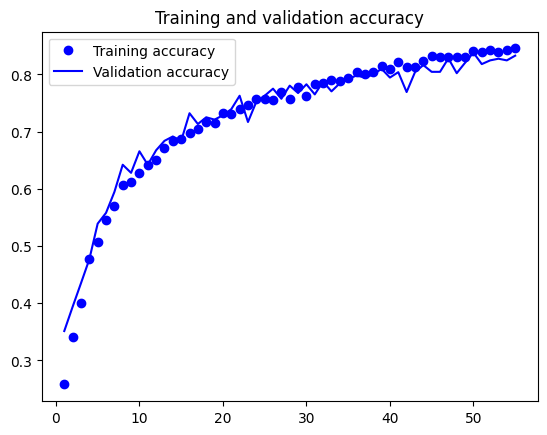

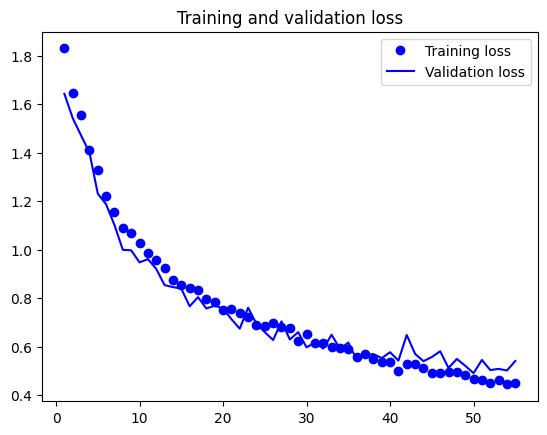

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# Évaluation du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print('\nTest accuracy:', test_acc)

27/27 - 2s - 67ms/step - accuracy: 0.8754 - loss: 0.3727

Test accuracy: 0.8754406571388245
